<a href="https://colab.research.google.com/github/dding3/BigDL/blob/addoutput/python/dllib/colab-notebook/dllib_keras_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

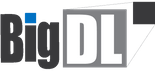

##### Copyright 2016 The BigDL Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

## **Environment Preparation**

**Install bigdl-dllib**

You can install the latest pre-release version using `pip install --pre --upgrade bigdl-dllib`. 

In [2]:
# Install latest pre-release version of bigdl-dllib with spark3
# Find the latest bigdl-dllib with spark3 from https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/ and intall it
!pip install https://sourceforge.net/projects/analytics-zoo/files/dllib-py-spark3/bigdl_dllib_spark3-0.14.0b20211107-py3-none-manylinux1_x86_64.whl

exit() # restart the runtime to refresh installed pkg

     |████████████████████████████████| 93.9 MB 10 kB/s 
     |████████████████████████████████| 212.4 MB 56 kB/s 
     |████████████████████████████████| 198 kB 51.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=12522ef0b9b3e431f5fa73999c4a989ad87b4706508a1e68904ec038407dd3e4
  Stored in directory: /root/.cache/pip/wheels/a5/0a/c1/9561f6fecb759579a7d863dcd846daaa95f598744e71b02c77
Successfully built pyspark


## **Distributed NN model using DLlib keras-style api for classification**

In this guide we will demonstrate how to use dllib keras-style api to build a model for classification in 5 simple steps.

#### **Step 0: Intialization** 

import necessary libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import lit
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from bigdl.dllib.nncontext import *
from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.model import *
from bigdl.dllib.nnframes import *
from bigdl.dllib.nn.criterion import *

Prepending /usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path


Init NNContext and create Spark session

In [2]:
sc = init_nncontext(cluster_mode="local") # run in local mode
spark = SparkSession(sc)

Current pyspark location is : /usr/local/lib/python3.7/dist-packages/pyspark/__init__.py
Start to getOrCreate SparkContext
pyspark_submit_args is:  --driver-class-path /usr/local/lib/python3.7/dist-packages/bigdl/share/dllib/lib/bigdl-dllib-spark_3.1.2-0.14.0-SNAPSHOT-jar-with-dependencies.jar pyspark-shell 
Successfully got a SparkContext


#### **Step 1: Load the data** 

We used [Pima Indians onset of diabetes](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv) as dataset for the demo. It's a standard machine learning dataset from the UCI Machine Learning repository. It describes patient medical record data for Pima Indians and whether they had an onset of diabetes within five years.    

For more details about the data, please refer [here](https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names)





##### ***Download the data***


In [3]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv


--2021-11-08 06:18:16--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23278 (23K) [text/plain]
Saving to: ‘pima-indians-diabetes.data.csv’

pima-indians-diabet 100%[===================>]  22.73K  --.-KB/s    in 0.002s  

2021-11-08 06:18:16 (9.86 MB/s) - ‘pima-indians-diabetes.data.csv’ saved [23278/23278]




DLlib supports Spark Dataframes as the input to the distributed training, and as the input/output of the distributed inference. Consequently, the user can easily process large-scale dataset using Apache Spark, and directly apply AI models on the distributed (and possibly in-memory) Dataframes without data conversion or serialization   

##### **Load the data into Spark dataframe using Spark API**

In [4]:
path = "pima-indians-diabetes.data.csv"
df = spark.read.csv(path, sep=',', inferSchema=True).toDF("num_times_pregrant", "plasma_glucose", "blood_pressure", "skin_fold_thickness", "2-hour_insulin", "body_mass_index", "diabetes_pedigree_function", "age", "class")

#### **Step 2: Process data using Spark DataFrame api** 


In [5]:
vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["num_times_pregrant", "plasma_glucose", "blood_pressure", "skin_fold_thickness", "2-hour_insulin", "body_mass_index", "diabetes_pedigree_function", "age"])
train_df = vecAssembler.transform(df)

changedTypedf = train_df.withColumn("label", train_df["class"].cast(DoubleType())+lit(1))\
    .select("features", "label")
(trainingDF, validationDF) = changedTypedf.randomSplit([0.9, 0.1])


#### **Step 3: Define model using DLlib keras-style api** 


In [6]:
x1 = Input(shape=(8,))
dense1 = Dense(12, activation='relu')(x1)
dense2 = Dense(8, activation='relu')(dense1)
dense3 = Dense(2)(dense2)
model = Model(x1, dense3)

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel


#### **Step 4: Create NNClassifier**

In [7]:
classifier = NNClassifier(model, CrossEntropyCriterion(), [8]) \
    .setOptimMethod(Adam()) \
    .setBatchSize(32) \
    .setMaxEpoch(150)

creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier
creating: createAdam


Train the model with Spark dataframe

In [8]:
nnModel = classifier.fit(trainingDF)

creating: createToTuple
creating: createChainedPreprocessing


#### **Step 5: Evaluate the trained model**

In [9]:
predictionDF = nnModel.transform(validationDF).cache()
predictionDF.sample(False, 0.1).show()


evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictionDF)

print("Accuracy = %g " % (accuracy))


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[0.0,121.0,66.0,3...|  2.0|       1.0|
|[1.0,73.0,50.0,10...|  1.0|       1.0|
|[1.0,81.0,72.0,18...|  1.0|       1.0|
|[1.0,93.0,56.0,11...|  1.0|       1.0|
|[1.0,149.0,68.0,2...|  2.0|       1.0|
|[2.0,112.0,86.0,4...|  1.0|       1.0|
|[3.0,96.0,56.0,34...|  1.0|       1.0|
|[4.0,151.0,90.0,3...|  1.0|       1.0|
|[6.0,162.0,62.0,0...|  2.0|       1.0|
|[7.0,107.0,74.0,0...|  2.0|       1.0|
|[8.0,181.0,68.0,3...|  2.0|       2.0|
|[14.0,175.0,62.0,...|  2.0|       2.0|
+--------------------+-----+----------+

Accuracy = 0.690141 
